### **Notebook 3 — Feature Engineering & Machine Learning**

This notebook is the heart of the project.
- Notebook-1 prepared the data.
- Notebook-2 understood and validated the data.
- Notebook-3 teaches the model how to think.

Objective:
Build a machine learning model to predict Store Sales.

Input:
- final_train.csv
- final_test.csv

Pipeline:
1. Load prepared datasets
2. Feature engineering & feature extraction
3. Encode categorical variables
4. Standardize features
5. Train Machine Learning model
6. Evaluate performance
7. Save trained model (.pkl)

Important Note:
Linear Regression and Logistic Regression are not suitable because:
- Dataset is very large (lakhs of rows)
- Sales relationship is non-linear
- Multiple categorical variables exist

Recommended Model:
Random Forest Regressor


#### **IMPORTING MODULES/LIBRARIES**
This section will import all the libraries or modules required to add details in the cleaning and EDA process.

In [59]:
import io
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import lightgbm as lgb
import joblib
from datetime import datetime

#### **LOGGER SETUP**
The root logger already has handlers so logging.basicConfig() is ignored — no file handler gets added. Hence, we can either replace logger setup with an explicit FileHandler (robust) or we can use `basicConfig(..., force=True)`

We will be using `basicConfig(..., force=True)`

In [60]:
if not os.path.exists("logs"):
    os.makedirs("logs")

logging.basicConfig(
    filename="logs/model_training.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    force=True
)

logger = logging.getLogger(__name__)

def print_and_log(message, level='info'):
    print(message)
    if level == 'info':
        logger.info(message)
    elif level == 'warning':
        logger.warning(message)
    elif level == 'error':
        logger.error(message)
    else:
        logger.debug(message) 
              
print_and_log("===== MODEL TRAINING STARTED =====")

===== MODEL TRAINING STARTED =====


#### **STEP 1 — LOAD CLEAN DATASETS**

Load Final Prepared Dataset:
- final_train.csv
- final_test.csv

In [61]:
print_and_log("Loading datasets...")
train = pd.read_csv("final_train.csv", parse_dates=["date"], low_memory=False)
test = pd.read_csv("final_test.csv", parse_dates=["date"], low_memory=False)

print_and_log(f"Train shape: {train.shape}")
print_and_log(f"Test shape: {test.shape}")
print_and_log("Train data first 5 rows:")
display(train.head())
print_and_log("Test data first 5 rows:")
display(test.head())
print_and_log("Datasets loaded successfully!")

Loading datasets...
Train shape: (844338, 24)
Test shape: (41088, 17)
Train data first 5 rows:


,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,storetype,...,promo2,promo2sinceweek,promo2sinceyear,promointerval,year,month,day,weekday,weekofyear,is_weekend
0,1,5,2015-07-31,5263.0,555,1,1,0,0,c,...,0,0.0,0.0,NaN,2015,7,31,4,31,0
1,2,5,2015-07-31,6064.0,625,1,1,0,0,a,...,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,4,31,0
2,3,5,2015-07-31,8314.0,821,1,1,0,0,a,...,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,4,31,0
3,4,5,2015-07-31,13611.5,1454,1,1,0,0,c,...,0,0.0,0.0,NaN,2015,7,31,4,31,0
4,5,5,2015-07-31,4822.0,559,1,1,0,0,a,...,0,0.0,0.0,NaN,2015,7,31,4,31,0


Test data first 5 rows:


,id,store,dayofweek,date,open,promo,stateholiday,schoolholiday,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
0,1,1,4,2015-09-17,1,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN
1,2,3,4,2015-09-17,1,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1,1,0,0,a,c,24000.0,4.0,2013.0,0,0.0,0.0,NaN
3,4,8,4,2015-09-17,1,1,0,0,a,a,7520.0,10.0,2014.0,0,0.0,0.0,NaN
4,5,9,4,2015-09-17,1,1,0,0,a,c,2030.0,8.0,2000.0,0,0.0,0.0,NaN


Datasets loaded successfully!


_____________________________________________

#### **STEP 1a - SANITY CHECK**
Verify columns, nulls, and target variable.

In [62]:
logger.info("Checking missing values")
print(train.isnull().sum())

assert "sales" in train.columns, "Sales column missing in train dataset"
print_and_log("Sanity check passed")

store                             0
dayofweek                         0
date                              0
sales                             0
customers                         0
open                              0
promo                             0
stateholiday                      0
schoolholiday                     0
storetype                         0
assortment                        0
competitiondistance               0
competitionopensincemonth         0
competitionopensinceyear          0
promo2                            0
promo2sinceweek                   0
promo2sinceyear                   0
promointerval                423292
year                              0
month                             0
day                               0
weekday                           0
weekofyear                        0
is_weekend                        0
dtype: int64
Sanity check passed


_____________________________________________

#### **STEP 2 — FEATURE ENGINEERING**
We extract meaningful features from date and business columns.

In [63]:
logger.info("Performing feature engineering...")

for df in [train, test]:
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["weekday"] = df["date"].dt.weekday
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
    df["is_weekend"] = df["weekday"].apply(lambda x: 1 if x>=5 else 0)

print_and_log(
    "Temporal features engineered from 'date' column to capture seasonality and weekly sales patterns: "
    "year, month, day, weekday, weekofyear, is_weekend added to train and test datasets."
)

Temporal features engineered from 'date' column to capture seasonality and weekly sales patterns: year, month, day, weekday, weekofyear, is_weekend added to train and test datasets.


_____________________________________________

### **STEP 3 — FEATURE EXTRACTION**
3.1 We remove unnecessary columns that do not help prediction.

In [64]:
logger.info("Dropping non-informative columns...")
drop_cols = ["date"]

train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)
print_and_log("Dropped non-informative columns")

Dropped non-informative columns


3.2 Lag Features (for Sales)

In [65]:
logger.info("Creating lag features for time series modeling...")
train['Lag_1'] = train.groupby('store')['sales'].shift(1)
train['Lag_7'] = train.groupby('store')['sales'].shift(7)
train['Rolling_7'] = train.groupby('store')['sales'].shift(1).rolling(7).mean()

train = train.dropna()
print_and_log(f"Lag features created and missing values dropped from training set!\n{train.shape}")

Lag features created and missing values dropped from training set!
(417045, 26)


3.3 Remove Closed Stores & Zero Sales

In [66]:
logger.info("Removing closed stores and zero sales from training data...")
train = train[(train['open'] == 1) & (train['sales'] > 0)]
print_and_log(f"Closed stores and zero sales removed from training set!\n{train.shape}")

Closed stores and zero sales removed from training set!
(417045, 26)


_____________________________________________

### **STEP 4 — ENCODING CATEGORICAL VARIABLES**
Random Forest requires numeric input.
We convert categorical features using Label Encoding.

In [67]:
logger.info("Starting categorical encoding process...")
categorical_cols = train.select_dtypes(include=["object","category"]).columns
encoders = {}

# Fit encoders on combined data to avoid unseen-label errors on test
for col in categorical_cols:
    le = LabelEncoder()
    combined = pd.concat([train[col].astype(str), test[col].astype(str)], axis=0).fillna('')
    le.fit(combined)
    train[col] = le.transform(train[col].astype(str))
    # For test, map and set unknowns to -1 if any appear (safety)
    try:
        test[col] = le.transform(test[col].astype(str))
    except ValueError:
        test[col] = test[col].astype(str).map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    encoders[col] = le

print_and_log("Categorical encoding completed for columns: " + ", ".join(categorical_cols))

Categorical encoding completed for columns: stateholiday, storetype, assortment, promointerval


_____________________________________________

#### **STEP 5 — SPLIT FEATURES & TARGET**
Split Features and Target Variable
- Target variable = Sales

In [68]:
logger.info("starting to split features and target...")
X = train.drop("sales", axis=1)
y = train["sales"]
print_and_log("Features and target variable separated for model training.")

Features and target variable separated for model training.


_____________________________________________

#### **STEP 6 — TRAIN VALIDATION SPLIT**

In [69]:
logger.info("Performing train-validation split...")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print_and_log(f"Train-validation split completed!\n {len(X_train)} samples in training set, {len(X_val)} samples in validation set.")


Train-validation split completed!
 333636 samples in training set, 83409 samples in validation set.


_____________________________________________

#### **STEP 7 - FEATURE SCALING**

In [70]:
logger.info("Starting feature scaling using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
print_and_log("Scaling completed using StandardScaler")

Scaling completed using StandardScaler


_____________________________________________

#### **STEP 7 — NORMALIZATION / STANDARDIZATION**
Random Forest does not strictly require scaling, but the project requirements are such that we include it.

In [71]:
logger.info("Starting Normalization and standardization...")
scaler = StandardScaler()

# Ensure test has the same feature columns and order as X (training features)
X_test = test.reindex(columns=X.columns, fill_value=0)

# Fit scaler on training features only and transform all splits
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames with feature names to avoid LightGBM warnings
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print_and_log(f"Normalization and standardization completed!\n{X_train_scaled.shape[1]} features scaled for training, validation, and test sets.")

Normalization and standardization completed!
25 features scaled for training, validation, and test sets.


_____________________________________________

#### **STEP 8 — MODEL TRAINING (RANDOM FOREST)**

Important:
Linear Regression and Logistic Regression are not suitable because:
- Dataset is large (lakhs of rows)
- Sales relationship is non-linear
- Many categorical variables exist

Therefore we use Random Forest Regressor.

8.1 Random Forest Regressor details

In [72]:
logger.info("Displaying Random Forest Regressor default parameters for reference...")
rf_model = RandomForestRegressor()
params = rf_model.get_params()

print_and_log("Random Forest Regressor Default Parameters:")
for key in sorted(params.keys()):
    print_and_log(f"{key:<25} : {params[key]}")

print_and_log("Random Forest parameters displayed successfully!")

Random Forest Regressor Default Parameters:
bootstrap                 : True
ccp_alpha                 : 0.0
criterion                 : squared_error
max_depth                 : None
max_features              : 1.0
max_leaf_nodes            : None
max_samples               : None
min_impurity_decrease     : 0.0
min_samples_leaf          : 1
min_samples_split         : 2
min_weight_fraction_leaf  : 0.0
monotonic_cst             : None
n_estimators              : 100
n_jobs                    : None
oob_score                 : False
random_state              : None
verbose                   : 0
warm_start                : False
Random Forest parameters displayed successfully!



8.2 We will do it using:`LightGBM`

LightGBM is 5-10x faster than Random Forest on large datasets because it:

- Grows trees leaf-wise (more efficient)
- Uses histogram-based learning
- Has better memory efficiency

In [73]:
logger.info("Initializing and training LightGBM Regressor (faster alternative)...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train_scaled, y_train)
logger.info("LightGBM training completed!")

# Evaluate LightGBM
lgb_preds = lgb_model.predict(X_val_scaled)
print_and_log("LightGBM Performance:")
print_and_log(f"RMSE: {np.sqrt(mean_squared_error(y_val, lgb_preds)):.4f}")
print_and_log(f"MAE: {mean_absolute_error(y_val, lgb_preds):.4f}")
print_and_log(f"R2 Score: {r2_score(y_val, lgb_preds):.4f}")

LightGBM Performance:
RMSE: 591.1658
MAE: 435.0734
R2 Score: 0.9456


_____________________________________________

#### **STEP 9 — VALIDATION SET STATISTICS**
Analyzing the distribution and characteristics of the validation set sales data.


In [74]:
logger.info("Analyzing validation set sales statistics...")

print_and_log("Validation Set Sales Statistics:")
print_and_log(f"Minimum Sales: {y_val.min()}")
print_and_log(f"Maximum Sales: {y_val.max()}")
print_and_log(f"Mean Sales: {y_val.mean():.2f}")
print_and_log(f"Number of Zero Sales: {(y_val == 0).sum()}")

print_and_log("Validation set statistics analysis completed!")

Validation Set Sales Statistics:
Minimum Sales: 297.0
Maximum Sales: 13611.5
Mean Sales: 6502.09
Number of Zero Sales: 0
Validation set statistics analysis completed!


_____________________________________________

#### **STEP 10 — Feature Importance (Random Forest)**

Top 10 Most Important Features:
competitiondistance         379
customers                   368
store                       360
dayofweek                   250
Lag_1                       231
storetype                   168
day                         159
promo2sinceweek             157
promo2sinceyear             154
competitionopensinceyear    133


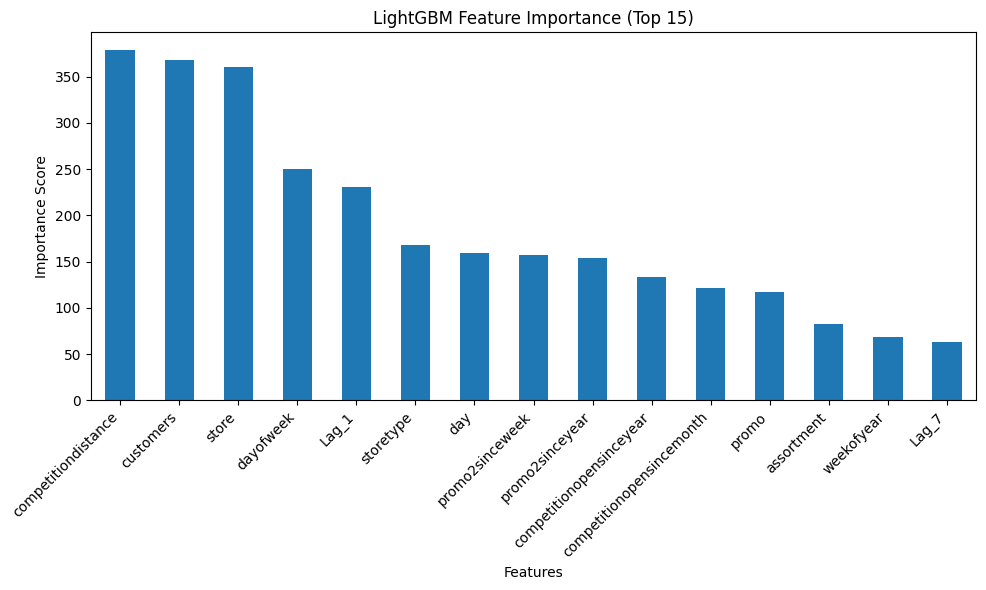

Feature importance analysis completed!


In [75]:
logger.info("Generating feature importance plot for LightGBM...")

# Extract feature importance from LightGBM model
feature_importance = pd.Series(
    lgb_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print_and_log("Top 10 Most Important Features:")
print_and_log(feature_importance.head(10).to_string())

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance.head(15).plot(kind='bar')
plt.title("LightGBM Feature Importance (Top 15)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print_and_log("Feature importance analysis completed!")

_____________________________________________

#### **STEP 11 — MODEL PERSISTENCE & VERSIONING**

Save the trained LightGBM model, scalers, and encoders to disk for production deployment.

**Key Components Saved:**
- **LightGBM Model** – Timestamped and latest versions for version control
- **StandardScaler** – Essential for preprocessing new data with consistent scaling
- **Label Encoders** – Maintains categorical encoding consistency across datasets

This ensures reproducibility and enables seamless model deployment without retraining.


In [76]:
logger.info("Starting model persistence and versioning...")

# Create models directory if it doesn't exist
if not os.path.exists("models"):
    os.makedirs("models")
    print_and_log("Created 'models' directory for model storage")

# Generate timestamp for model versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"models/lightgbm_model_{timestamp}.pkl"

# Save trained LightGBM model with timestamp
joblib.dump(lgb_model, model_filename)
print_and_log(f"Model saved successfully at: {model_filename}")

# Also save the latest model with a static name for easy access
latest_model_path = "models/lightgbm_model_latest.pkl"
joblib.dump(lgb_model, latest_model_path)
print_and_log(f"Latest model also saved at: {latest_model_path}")

# Save scaler for future use (essential for preprocessing new data)
scaler_path = "models/standard_scaler.pkl"
joblib.dump(scaler, scaler_path)
print_and_log(f"StandardScaler saved at: {scaler_path}")

# Save label encoders for categorical variables
encoders_path = "models/label_encoders.pkl"
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le   # IMPORTANT

# save dictionary
joblib.dump(encoders, encoders_path)
print_and_log(f"Label Encoders saved at: {encoders_path}")

Model saved successfully at: models/lightgbm_model_20260216_125602.pkl
Latest model also saved at: models/lightgbm_model_latest.pkl
StandardScaler saved at: models/standard_scaler.pkl
Label Encoders saved at: models/label_encoders.pkl


In [ ]:
logger.info("Creating a deployment-ready pipeline with preprocessor and model...")
# Use the already processed training data
numeric_cols = ["customers", "competitiondistance", "promo"]
categorical_cols = ["stateholiday", "storetype", "assortment"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols)
])

# Create pipeline with LightGBM
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", lgb.LGBMRegressor(n_estimators=300, n_jobs=-1, random_state=42, verbose=-1))
])

# Train on the full training data
pipeline.fit(X_train, y_train)

# Make predictions on validation set to verify pipeline works
pipeline_preds = pipeline.predict(X_val)
print_and_log("Pipeline Performance:")
print_and_log(f"RMSE: {np.sqrt(mean_squared_error(y_val, pipeline_preds)):.4f}")
print_and_log(f"MAE: {mean_absolute_error(y_val, pipeline_preds):.4f}")
print_and_log(f"R2 Score: {r2_score(y_val, pipeline_preds):.4f}")

# Save the pipeline
os.makedirs("models", exist_ok=True)
joblib.dump(pipeline, "models/sales_pipeline_latest.pkl")

logger.info("Final deployment pipeline saved successfully!")
print_and_log("Pipeline saved at: models/sales_pipeline_latest.pkl")

Pipeline Performance:
RMSE: 632.1004
MAE: 456.7355
R2 Score: 0.9378
Pipeline saved at: models/sales_pipeline_latest.pkl


c:\Users\Aishwarya Kr Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
